In [37]:
%matplotlib inline
import mxnet as mx
from mxnet import gluon,nd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from itertools import islice
from pathlib import Path
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas
from gluonts.dataset.artificial import ComplexSeasonalTimeSeries
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName

In [99]:
ctx = mx.cpu()
mx.random.seed(0)
np.random.seed(0)
ctx

cpu(0)

In [100]:
df = pd.read_csv("../data/CAISO-20170701-20201030.csv")
df.head()

,start_dt,end_dt,total_integrated_load_MW,solar_generation_MW,wind_generation_MW,covariate_x,ramp_z
0,2017-07-01 07:00:00+00:00,2017-07-01 08:00:00+00:00,25703,-31.09459,2881.98320,"[26, 5, 8]",22852.11139
1,2017-07-01 08:00:00+00:00,2017-07-01 09:00:00+00:00,24043,-30.83811,2765.90229,"[26, 5, 9]",21307.93582
2,2017-07-01 09:00:00+00:00,2017-07-01 10:00:00+00:00,22988,-30.48083,2791.72076,"[26, 5, 10]",20226.76007
3,2017-07-01 10:00:00+00:00,2017-07-01 11:00:00+00:00,22423,-31.98818,2549.59684,"[26, 5, 11]",19905.39134
4,2017-07-01 11:00:00+00:00,2017-07-01 12:00:00+00:00,22235,-32.67630,2502.67552,"[26, 5, 12]",19765.00078


In [101]:
import h5py
    with h5py.File('../data/train_data_seq_len_7.h5','r') as f:
        feat_dynamic_cat = f['covariate_x'][:]

IndentationError: unexpected indent (<ipython-input-101-e961460db339>, line 2)

In [102]:
df['end_dt'] = pd.to_datetime(df['end_dt'])
df['end_dt'][0]

Timestamp('2017-07-01 08:00:00+0000', tz='UTC')

In [103]:
train_size = 24*100

In [104]:
def create_dataset(num_series, num_steps, period=24, mu=1, sigma=0.3):
    df = pd.read_csv("../data/CAISO-20170701-20201030.csv")
    target = df['ramp_z'][:train_size].to_numpy().reshape(1,-1)
#     df['end_dt'] = df['end_dt'].apply(lambda )
    
    feat_dynamic_cat = np.random.randint(0,24,(target.shape[1],3))
    
    return target, feat_dynamic_cat
    

In [105]:
custom_ds_metadata = {'num_series': 1,
                      'num_steps': train_size,
                      'prediction_length': 24,
                      'freq': '1H',
                      'start': [pd.Timestamp("01-01-2019", freq='1H') 
                                for _ in range(1)]
                     }

In [106]:
data_out = create_dataset(custom_ds_metadata['num_series'], 
                          custom_ds_metadata['num_steps'],                                                      
                          custom_ds_metadata['prediction_length']
                         )

target, feat_dynamic_cat = data_out

In [107]:
for d in data_out:
    d = nd.array(d,ctx=ctx)

In [108]:
target.shape,feat_dynamic_cat.shape

((1, 2400), (2400, 3))

In [109]:
train_ds = ListDataset([{FieldName.TARGET: target, 
                         FieldName.START: start,
                         FieldName.FEAT_DYNAMIC_CAT: [fdc]}
                        for (target, start, fdc) in zip(target[:, :-custom_ds_metadata['prediction_length']], 
                                                             custom_ds_metadata['start'], 
                                                             feat_dynamic_cat[:, :-custom_ds_metadata['prediction_length']])],
                      freq=custom_ds_metadata['freq'])

In [110]:
test_ds = ListDataset([{FieldName.TARGET: target, 
                        FieldName.START: start,
                        FieldName.FEAT_DYNAMIC_CAT: [fdc],}
                       for (target, start, fdc) in zip(target, 
                                                        custom_ds_metadata['start'], 
                                                        feat_dynamic_cat)],
                     freq=custom_ds_metadata['freq'])

In [111]:
train_entry = next(iter(train_ds))
test_entry = next(iter(test_ds))
test_entry.keys(),train_entry.keys()


(dict_keys(['target', 'start', 'feat_dynamic_cat', 'source']),
 dict_keys(['target', 'start', 'feat_dynamic_cat', 'source']))

In [78]:
for k in train_entry.keys():
    train_entry['target'] = nd.array(train_entry['target'],ctx=ctx)
    test_entry['target'] = nd.array(test_entry['target'],ctx=ctx)

In [112]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.model.deepstate import DeepStateEstimator
from gluonts.trainer import Trainer

In [121]:
estimator = DeepStateEstimator(
    freq = custom_ds_metadata['freq'],
    prediction_length=custom_ds_metadata['prediction_length'],
    cardinality=[24],
    add_trend=True,
    past_length=train_size,
    use_feat_static_cat = False,
    trainer=Trainer(ctx=ctx, 
                epochs=1, 
                learning_rate=1e-3, 
                hybridize=False, 
                num_batches_per_epoch=10
               )
)

In [122]:
predictor = estimator.train(train_ds)

100%|██████████| 10/10 [04:27<00:00, 26.77s/it, epoch=1/1, avg_epoch_loss=0.281]


In [123]:
from gluonts.evaluation.backtest import make_evaluation_predictions 

In [147]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [148]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [149]:
ts_entry = tss[0]
np.array(ts_entry[:5]).reshape(-1,)

array([22852.111, 21307.936, 20226.76 , 19905.39 , 19765.   ],
      dtype=float32)

In [150]:
test_ds_entry = next(iter(test_ds))

In [151]:
test_ds_entry['target'][:5]

array([22852.111, 21307.936, 20226.76 , 19905.39 , 19765.   ],
      dtype=float32)

In [129]:
forecast_entry = forecasts[0]

In [155]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 24)
Start date of the forecast window: 2019-04-10 00:00:00
Frequency of the time series: 1H


In [161]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 24
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
#     plt.plot(forecast_entry.mean)
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

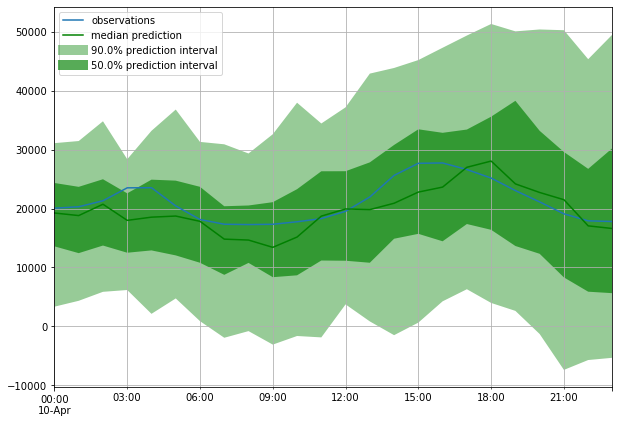

In [162]:
plot_prob_forecasts(ts_entry, forecast_entry)